# Splines

## Introduction
多くの場合、当てはめたいモデルは $x$ と $y$ の間の完全な線ではありません。
代わりに、モデルのパラメーターは $x$ を超えて変化すると予想されます。
この状況に対処するには複数の方法がありますが、その 1 つはスプラインをフィットさせることです。 スプライン フィットは事実上、複数の個別の曲線 (区分的多項式) の合計であり、それぞれが $x$ の異なるセクションにフィットし、しばしばノットと呼ばれる境界で結合されます。

スプラインは実質的に複数の個別の線であり、それぞれが $x$ の異なるセクションに適合し、境界 (多くの場合ノットと呼ばれます) で結び合わされます。

以下は、PyMC を使用してスプラインをフィットさせる方法の完全な実例です。 データとモデルは、[Richard McElreath's](https://xcelab.net/rm/) [[McElreath, 2018](https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_Lotka_Volterra_multiple_ways.html#id66)] による [Statistical Re Thinking 2e](https://xcelab.net/rm/statistical-rethinking/) から取得されています。

この非線形モデリング手法の詳細については、[Python におけるベイジアン モデリングと計算の第 5 章](https://bayesiancomputationbook.com/markdown/chp_05.html) [[Martin et al., 2021](https://www.pymc.io/projects/examples/en/latest/samplers/SMC-ABC_Lotka-Volterra_example.html#id62)] から始めることをお勧めします。

In [1]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from patsy import dmatrix

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 8927
az.style.use("arviz-darkgrid")

## Cherry blossom data
この例のデータは、各年 (```year```) に桜の木が咲いていた日数 (```doy```、「年間日数」を表す) です。 便宜上、```doy``'' が欠落している年は削除されました (これは一般的に欠落データを扱うのには悪い考えです!)。

In [3]:
try:
    # リポジトリ構成に合わせてパスを修正しました.
    blossom_data = pd.read_csv(Path("..", "..", "data", "cherry_blossoms.csv"), sep=";")
except FileNotFoundError:
    blossom_data = pd.read_csv(pm.get_data("cherry_blossoms.csv"), sep=";")


blossom_data.dropna().describe()

,year,doy,temp,temp_upper,temp_lower
count,787.000000,787.00000,787.000000,787.000000,787.000000
mean,1533.395172,104.92122,6.100356,6.937560,5.263545
std,291.122597,6.25773,0.683410,0.811986,0.762194
min,851.000000,86.00000,4.690000,5.450000,2.610000
25%,1318.000000,101.00000,5.625000,6.380000,4.770000
50%,1563.000000,105.00000,6.060000,6.800000,5.250000
75%,1778.500000,109.00000,6.460000,7.375000,5.650000
max,1980.000000,124.00000,8.300000,12.100000,7.740000


In [4]:
blossom_data = blossom_data.dropna(subset = ["doy"]).reset_index(drop = True)
blossom_data.head(n = 10)

,year,doy,temp,temp_upper,temp_lower
0,812,92.0,NaN,NaN,NaN
1,815,105.0,NaN,NaN,NaN
2,831,96.0,NaN,NaN,NaN
3,851,108.0,7.38,12.10,2.66
4,853,104.0,NaN,NaN,NaN
5,864,100.0,6.42,8.69,4.14
6,866,106.0,6.44,8.11,4.77
7,869,95.0,NaN,NaN,NaN
8,889,104.0,6.83,8.48,5.19
9,891,109.0,6.98,8.96,5.00


データが欠落している行を削除した後、木が開花していた日数は 827 年になります。

In [5]:
blossom_data.shape

(827, 5)

データを視覚化すると、年間変動が大きいことは明らかですが、開花日の長期にわたる非線形傾向を示す証拠もいくつかあります。

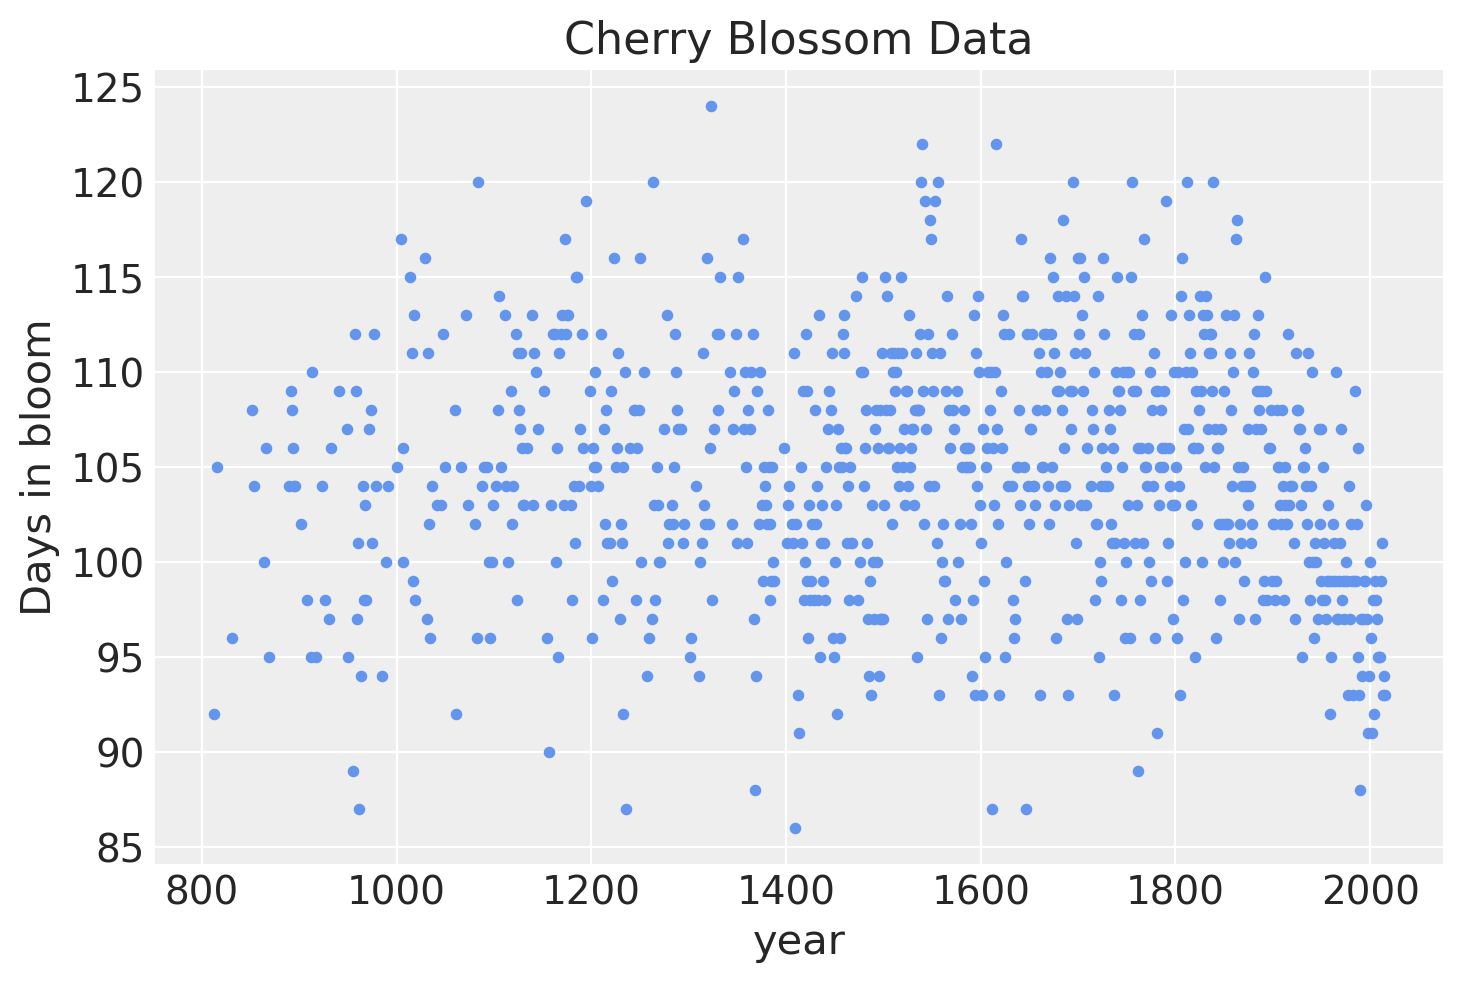

In [6]:
blossom_data.plot.scatter(
    "year", "doy", color = "cornflowerblue", s = 10, title = "Cherry Blossom Data", ylabel = "Days in bloom"
);

## The model
次の確率モデルを当てはめます。

$$
\begin{align}
D & \sim \mathcal{N} \bigl( \mu , \sigma ^2 \bigr)\\

\mu & = a + Bw\\

a & \sim \mathcal{N} \bigl( 100 , 10 ^2 \bigr)\\

w & \sim \mathcal{N} \bigl( 0 , 10 ^2 \bigr)\\

\sigma & \sim Exp(1)

\end{align}
$$

開花日数 $D$ は、平均 $\mu$ と標準偏差 $\sigma$ を持つ正規分布としてモデル化されます。
次に、平均は、y 切片 $a$ と、基底 $B$ に基底の各領域の変数を伴うモデル パラメーター $w$ を乗算して定義されるスプラインで構成される線形モデルになります。 どちらも比較的弱い正規事前分布を持っています。

### Prepare the spline
スプラインは 15 ノットを持ち、年を 16 のセクションに分割します (データがある年の前後の年をカバーする地域を含む)。 ノットはスプラインの境界であり、個々の線がこれらの境界で結び合わされて連続的で滑らかな曲線を作成する方法に由来する名前です。 各領域のデータの割合が同じになるように、ノットは長年にわたり不等間隔になります。

In [7]:
num_knots = 15
knot_list = np.quantile(blossom_data.year, np.linspace(0, 1, num_knots))
knot_list

array([ 812., 1036., 1174., 1269., 1377., 1454., 1518., 1583., 1650.,
       1714., 1774., 1833., 1893., 1956., 2015.])

Below is a plot of the locations of the knots over the data.

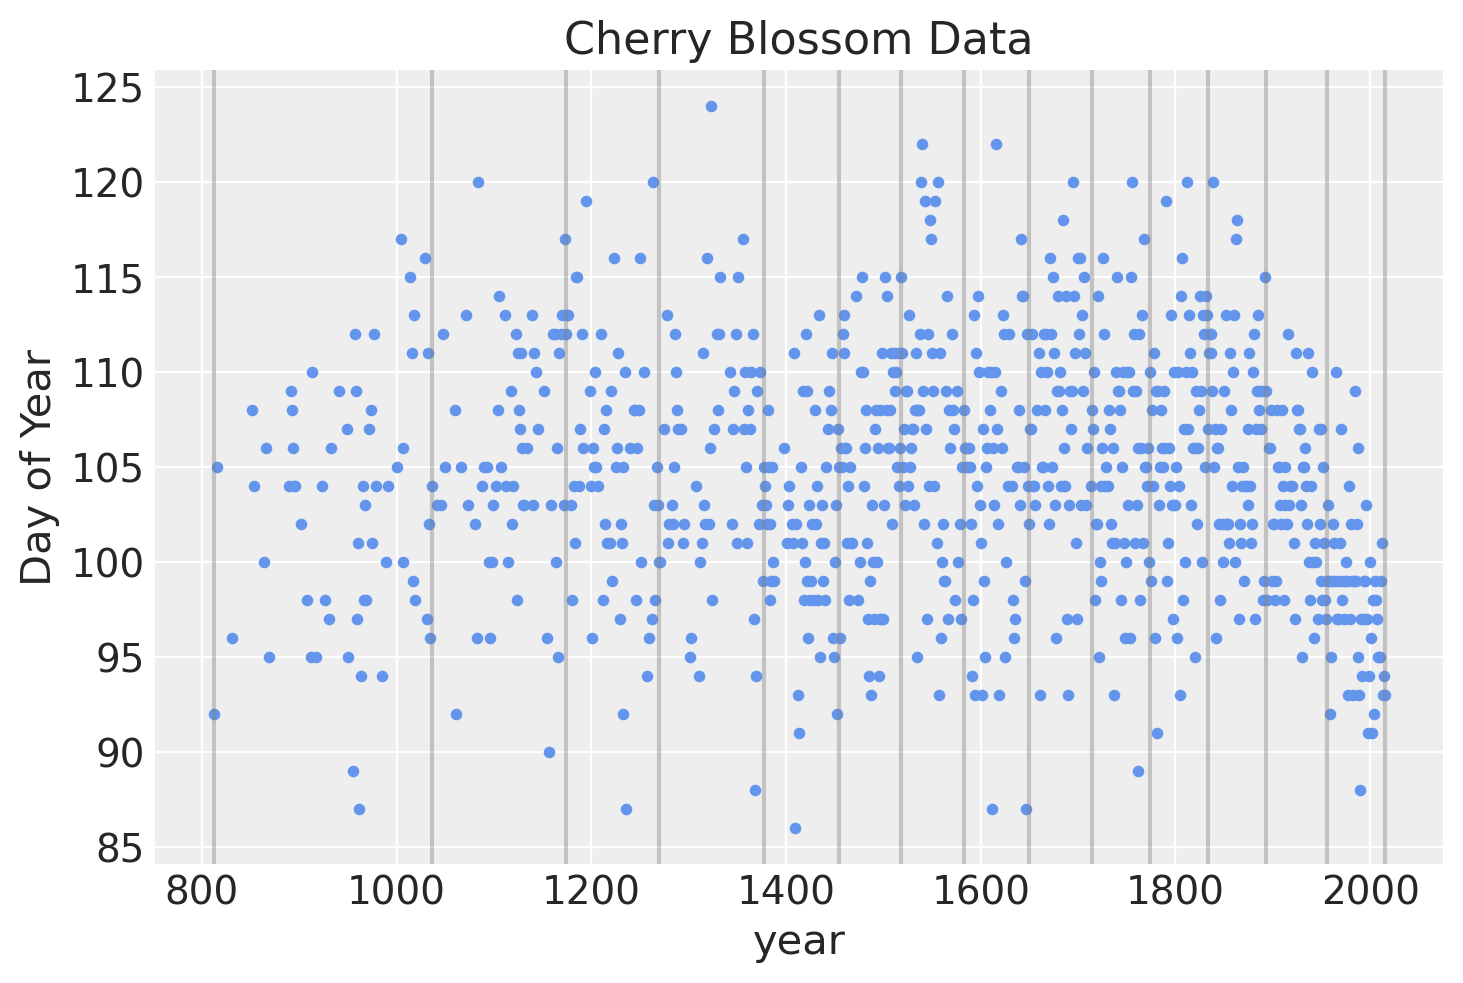

In [8]:
blossom_data.plot.scatter(
    "year", "doy", color = "cornflowerblue", s = 10, title = "Cherry Blossom Data", ylabel = "Day of Year"
)
for knot in knot_list:
    plt.gca().axvline(knot, color = "grey", alpha = 0.4);

```patsy``` を使用して、回帰の b スプライン基礎となる行列 $B$ を作成できます。 3 次 B スプラインを作成するには、次数を 3 に設定します。

In [9]:
B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": blossom_data.year.values, "knots": knot_list[1:-1]},
)
B

DesignMatrix with shape (827, 17)
  Columns:
    ['bs(year, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[4]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[5]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[6]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[7]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[8]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[9]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[10]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[11]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[12]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[13]',
     'bs(year

b-スプライン基底は以下にプロットされており、スプラインの各部分の領域を示しています。 各曲線の高さは、対応するモデルの共変量 (スプライン領域ごとに 1 つ) がその領域のモデルの推論にどの程度影響するかを示します。 重なっている領域は結び目を表し、ある領域から次の領域への滑らかな移行がどのように形成されるかを示しています。

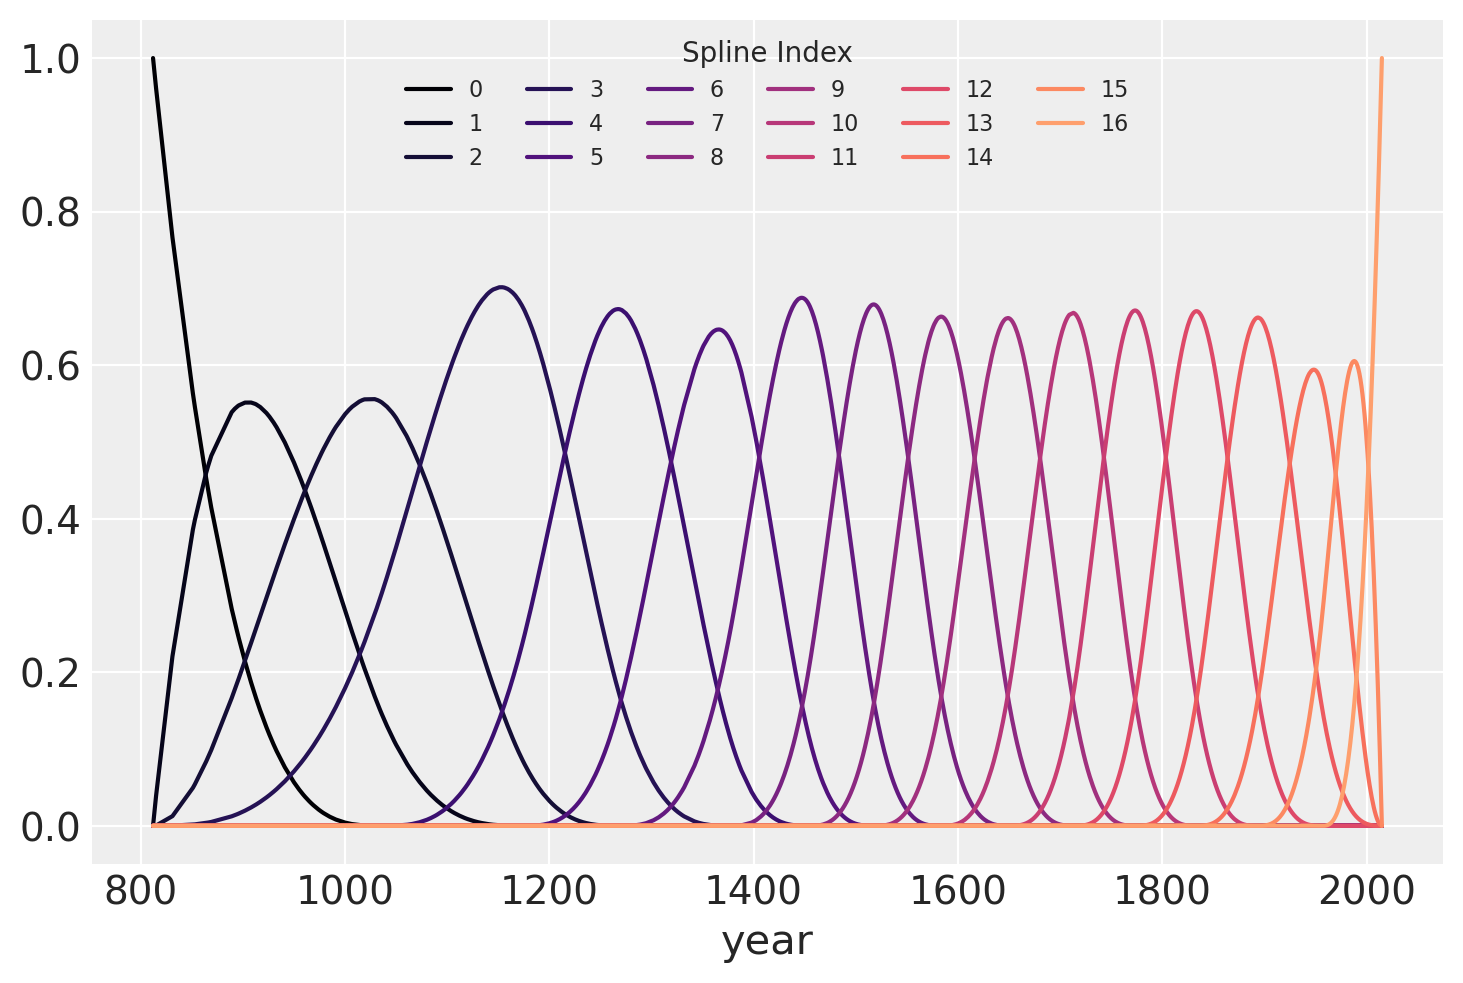

In [10]:
spline_df = (
    pd.DataFrame(B)
    .assign(year = blossom_data.year.values)
    .melt("year", var_name = "spline_i", value_name = "value")
)

color = plt.cm.magma(np.linspace(0, 0.80, len(spline_df.spline_i.unique())))

fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("year", "value", c = c, ax = plt.gca(), label = i)
plt.legend(title = "Spline Index", loc = "upper center", fontsize = 8, ncol = 6);

### Fit the model
最後に、PyMC を使用してモデルを構築できます。
グラフィカルな図はモデルパラメータの構成を示しています (これには python-graphviz のインストールが必要であることに注意してください。これは ``conda```` 仮想環境で行うことをお勧めします)。

In [11]:
# データ数のインデックス "obs" の定義が抜けていたので,コードを修正しました.
COORDS = {"splines": np.arange(B.shape[1]), "obs": np.arange(blossom_data.shape[0])}
with pm.Model(coords = COORDS) as spline_model:
    a = pm.Normal("a", 100, 5)
    w = pm.Normal("w", mu = 0, sigma = 3, size = B.shape[1], dims = "splines")
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order = "F"), w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu = mu, sigma = sigma, observed = blossom_data.doy, dims = "obs")

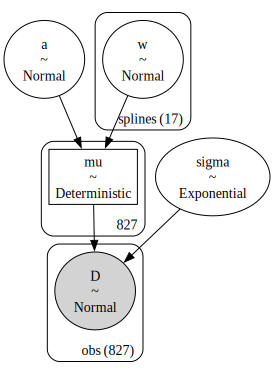

In [12]:
pm.model_to_graphviz(spline_model)

In [13]:
with spline_model:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(draws = 1000, tune = 1000, random_seed = RANDOM_SEED, chains = 4))
    pm.sample_posterior_predictive(idata, extend_inferencedata = True)

Sampling: [D, a, sigma, w]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, sigma]


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
Sampling: [D]


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

## Analysis
これで、モデルの後面からの描画を分析できるようになりました。

### Parameter Estimates
以下は、モデル パラメーターの事後分布をまとめた表です。
$a$ と $\sigma$ の事後分布は非常に狭いのに対し、$w$ の事後分布はより広いです。
  これは、$a$ と $\sigma$ の推定にすべてのデータ ポイントが使用されるのに対し、$w$ の各値にはサブセットのみが使用されるためと考えられます。
(これらを階層的にモデル化して情報の共有を可能にし、スプライン全体で正則化を追加することは興味深いかもしれません。) 有効サンプル サイズと $\hat{R}$ 値はすべて良好に見えます。これは、モデルが収束し、適切にサンプリングされていることを示しています。 事後分布。

In [14]:
az.summary(idata, var_names=["a", "w", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,103.680,0.782,102.154,105.147,0.020,0.014,1569.0,2227.0,1.0
w[0],-1.838,2.197,-5.947,2.198,0.031,0.026,4948.0,3345.0,1.0
w[1],-1.654,2.085,-5.570,2.260,0.035,0.027,3469.0,2819.0,1.0
w[2],-0.268,1.975,-4.132,3.314,0.033,0.028,3515.0,3193.0,1.0
w[3],3.323,1.459,0.638,6.117,0.028,0.020,2764.0,2704.0,1.0
w[4],0.120,1.567,-2.765,3.130,0.030,0.022,2790.0,3008.0,1.0
w[5],2.070,1.580,-0.798,5.157,0.028,0.020,3132.0,3506.0,1.0
w[6],-3.615,1.484,-6.445,-0.731,0.027,0.020,2973.0,3389.0,1.0
w[7],5.496,1.476,2.734,8.210,0.025,0.018,3461.0,3345.0,1.0
w[8],-0.107,1.566,-3.008,2.790,0.029,0.022,2885.0,3103.0,1.0


モデル パラメーターのトレース プロットは良好に見えます (均質で傾向の兆候がない)。さらに、チェーンが収束して混合していることを示しています。

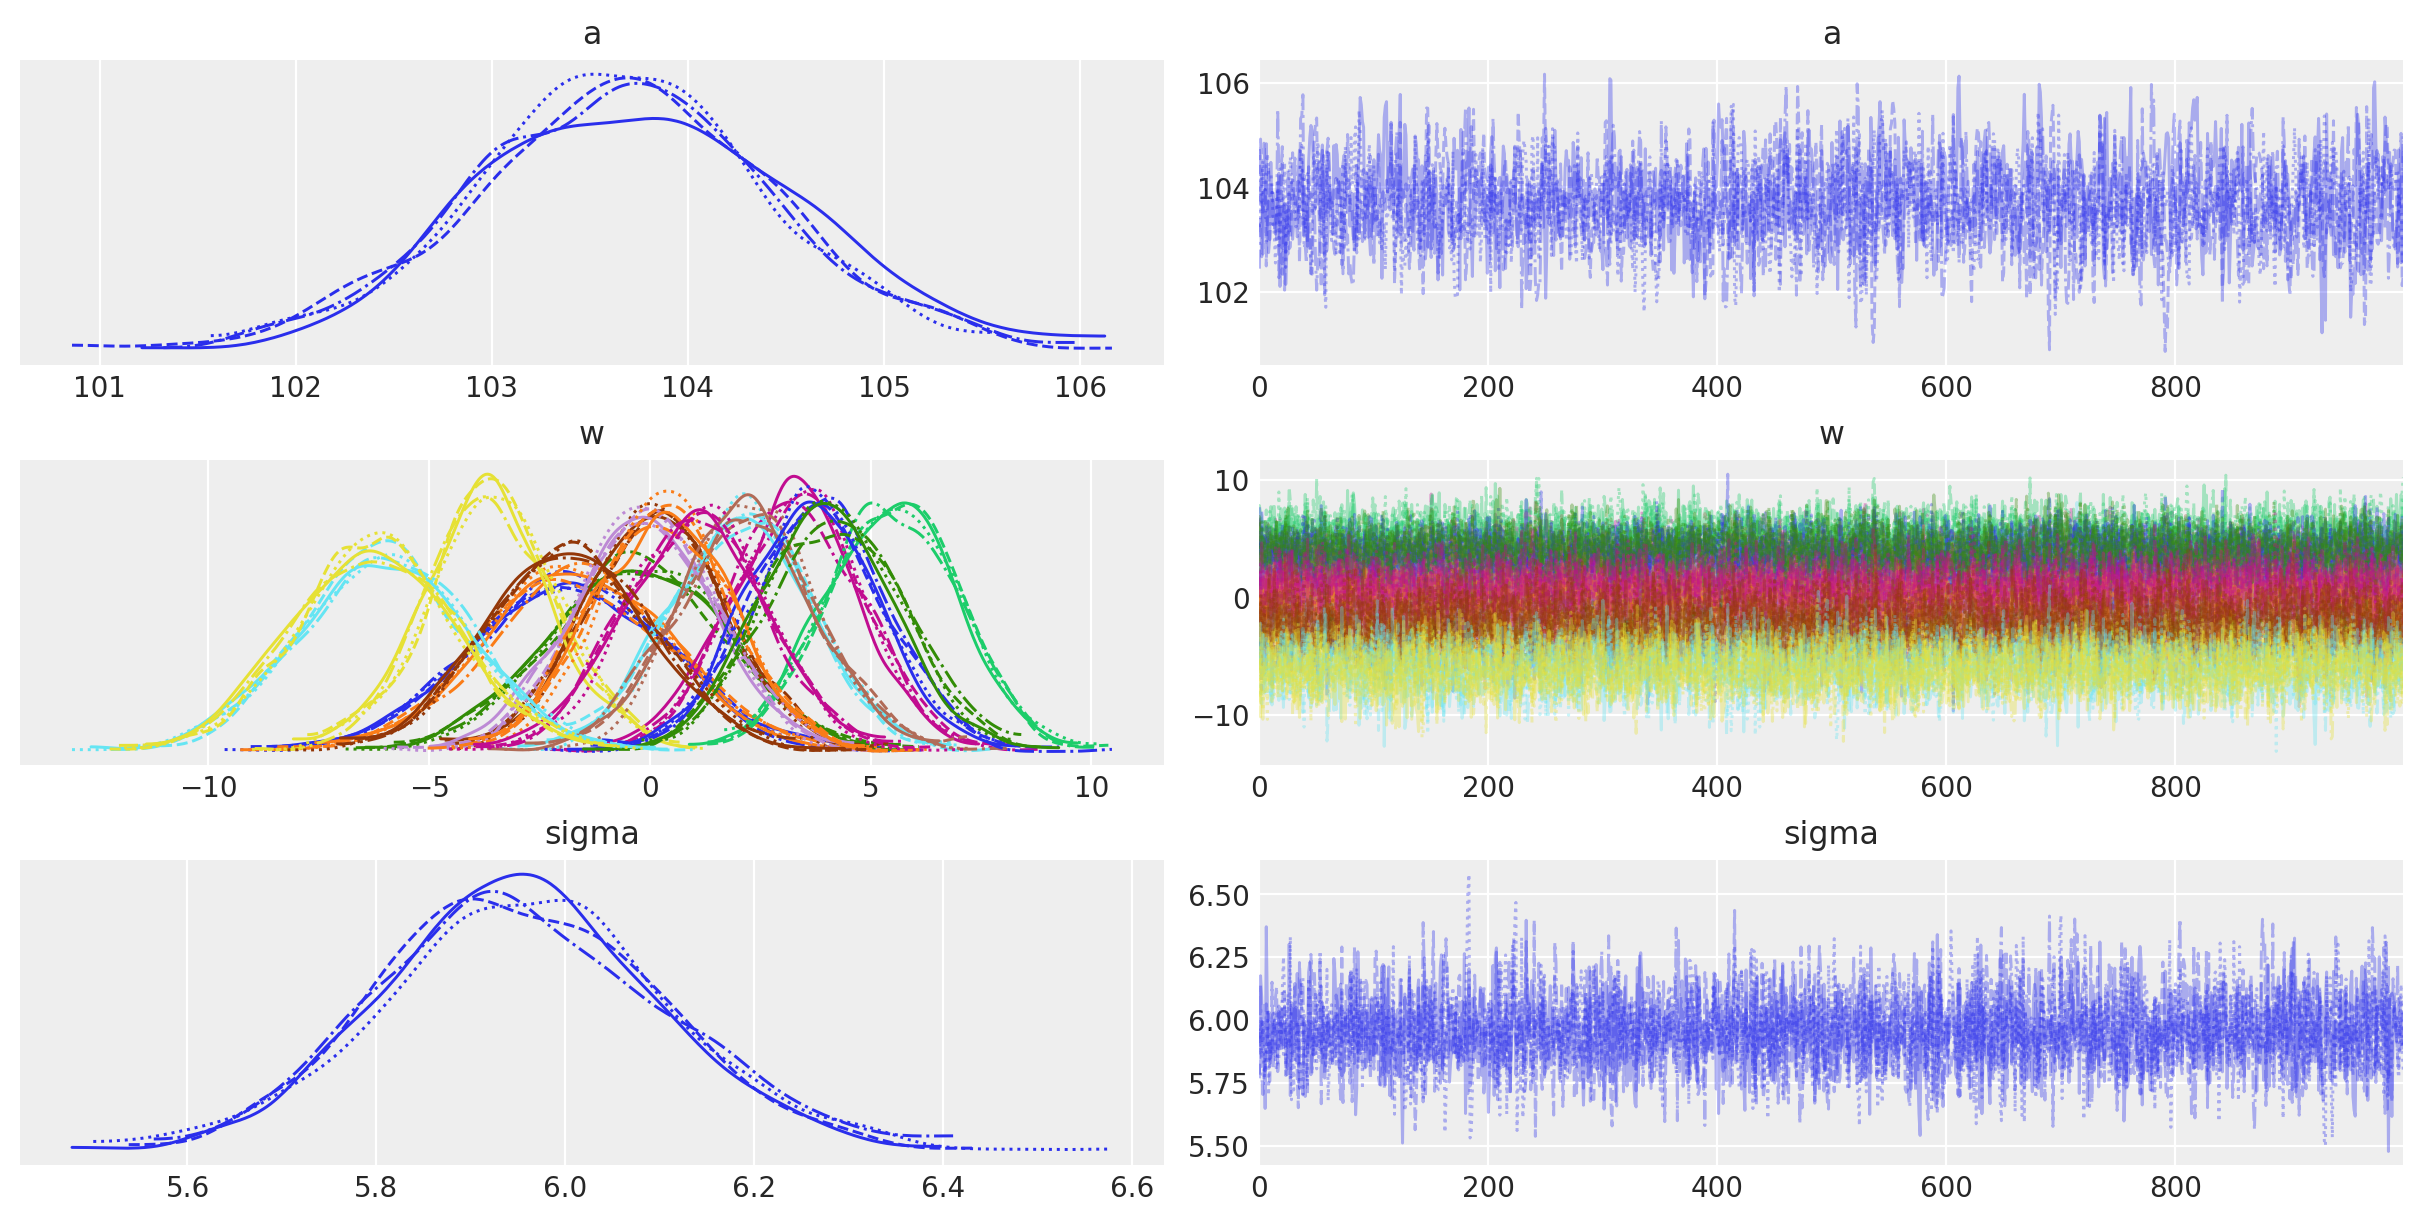

In [15]:
az.plot_trace(idata, var_names=["a", "w", "sigma"]);

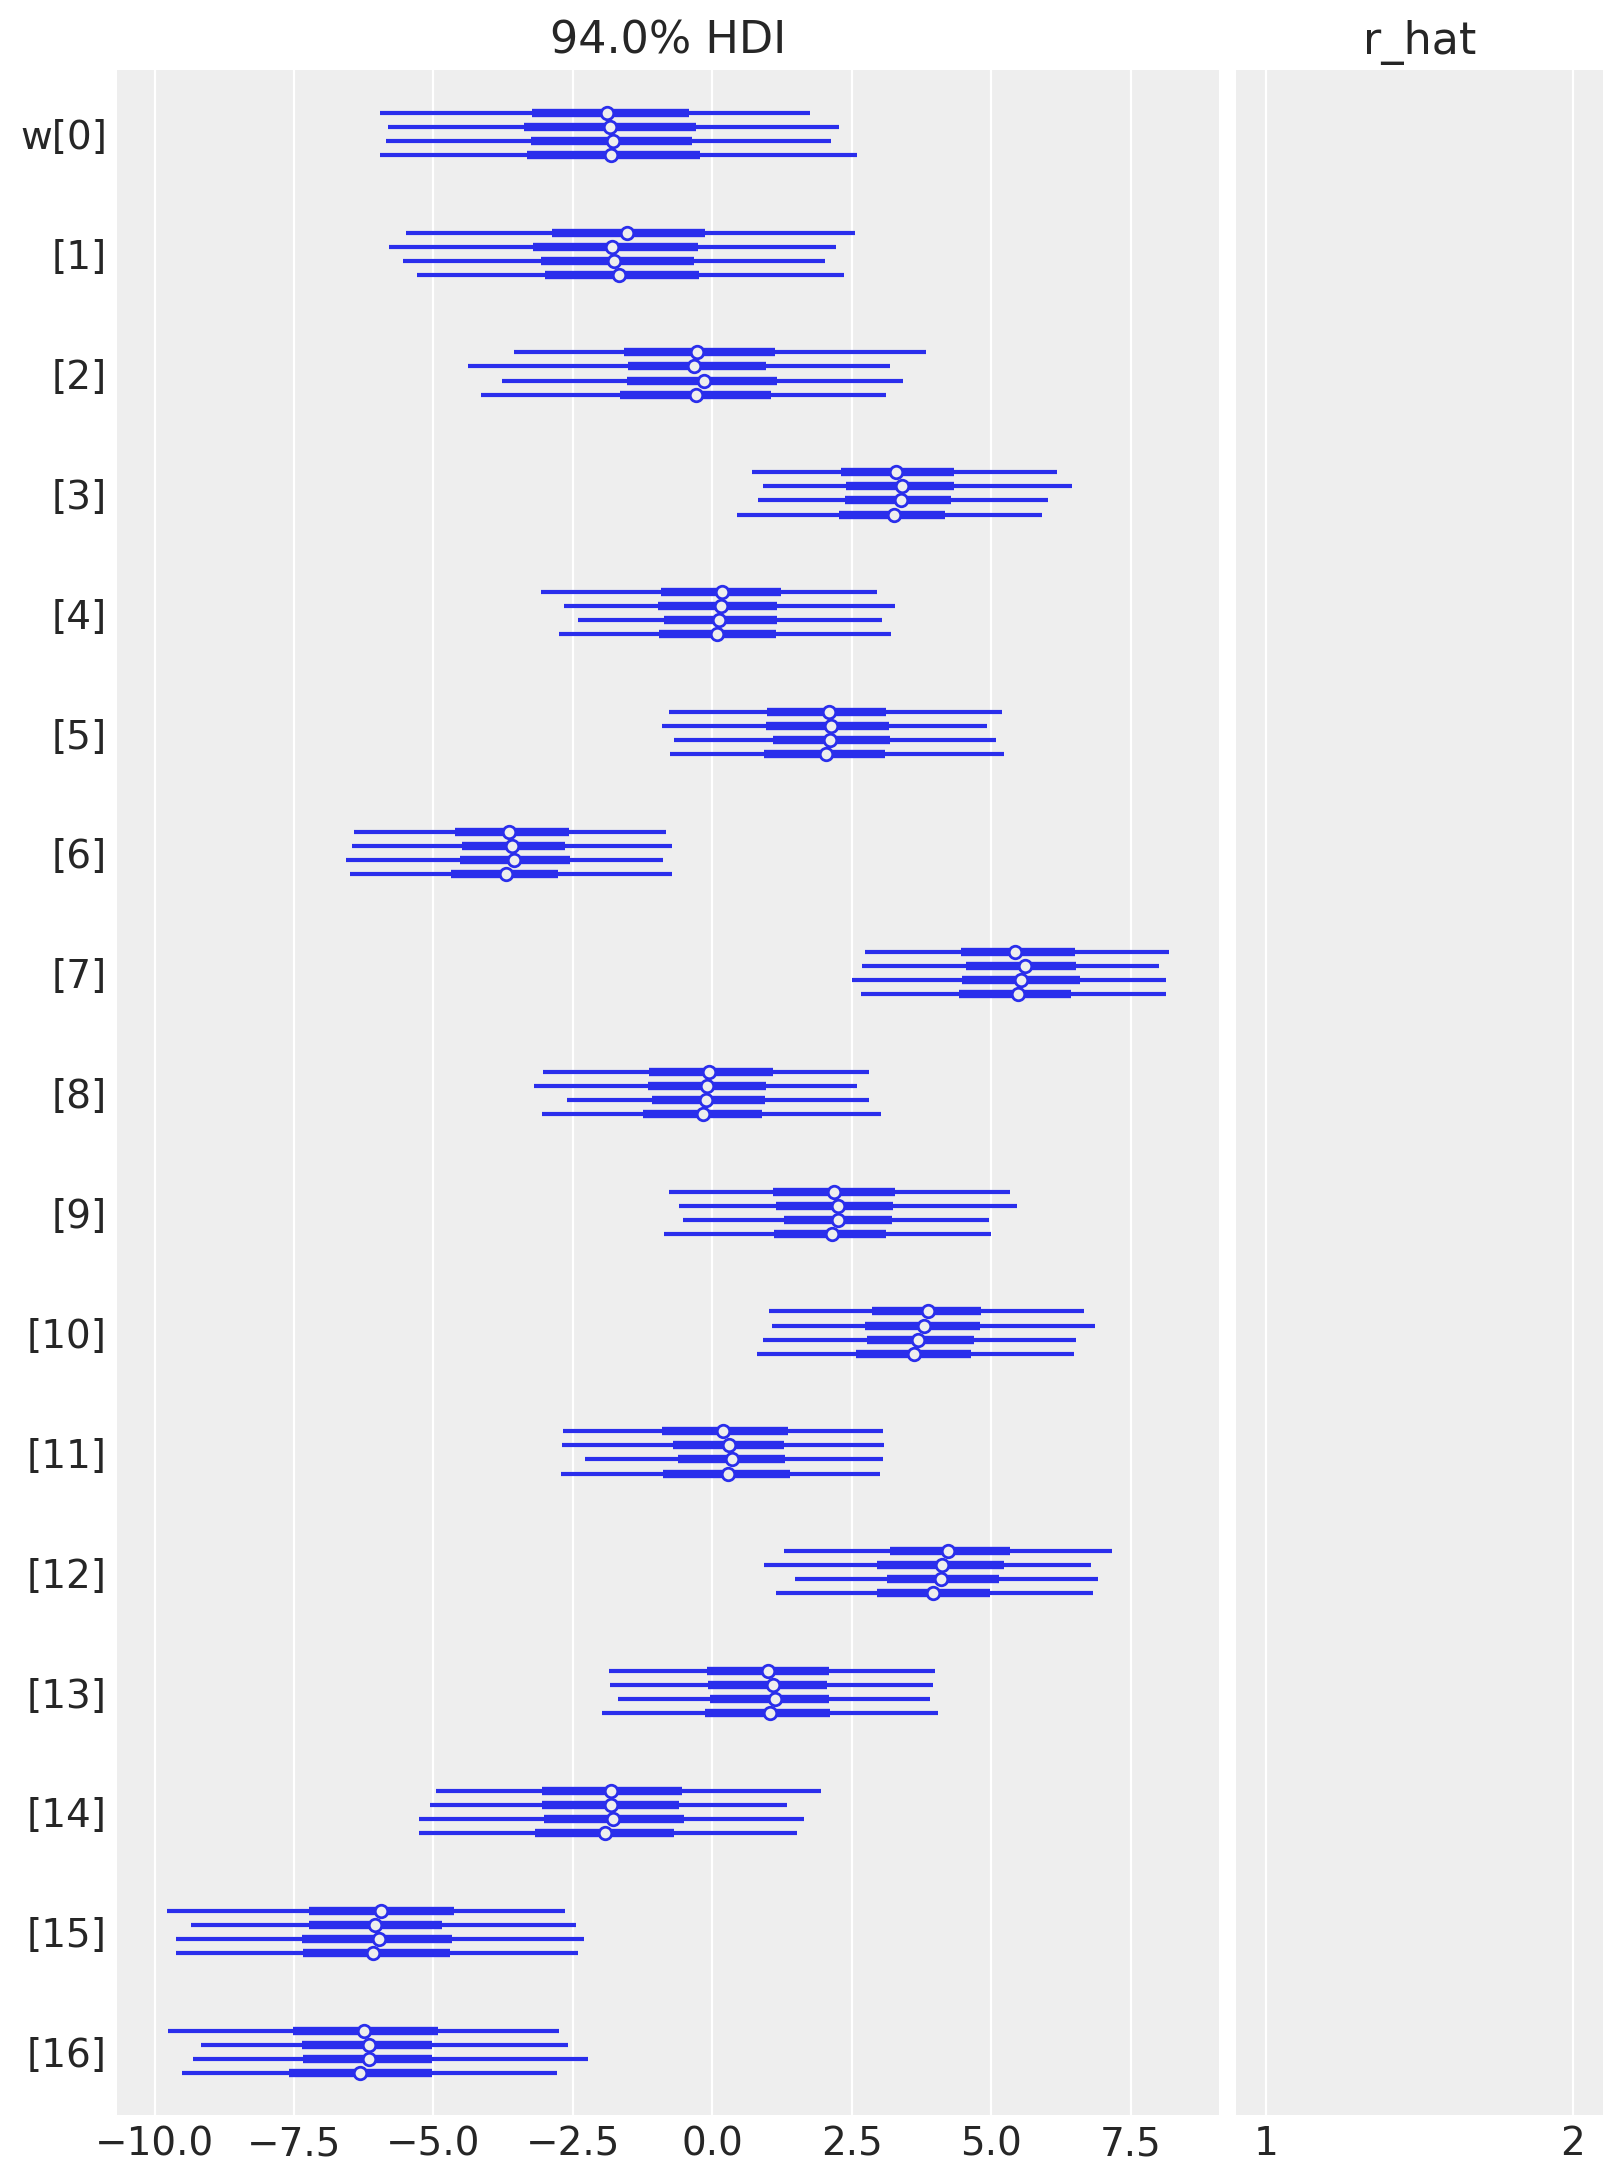

In [16]:
az.plot_forest(idata, var_names = ["w"], combined = False, r_hat = True);

フィット スプライン値のもう 1 つの視覚化は、それらを基底行列に対して乗算してプロットすることです。
ノットの境界は再び垂直線として表示されますが、$w$ の値に対してスプライン基底が乗算されます (虹色の曲線として表されます)。
$B$ と $w$ の内積 (線形モデルでの実際の計算) は黒で表示されます。

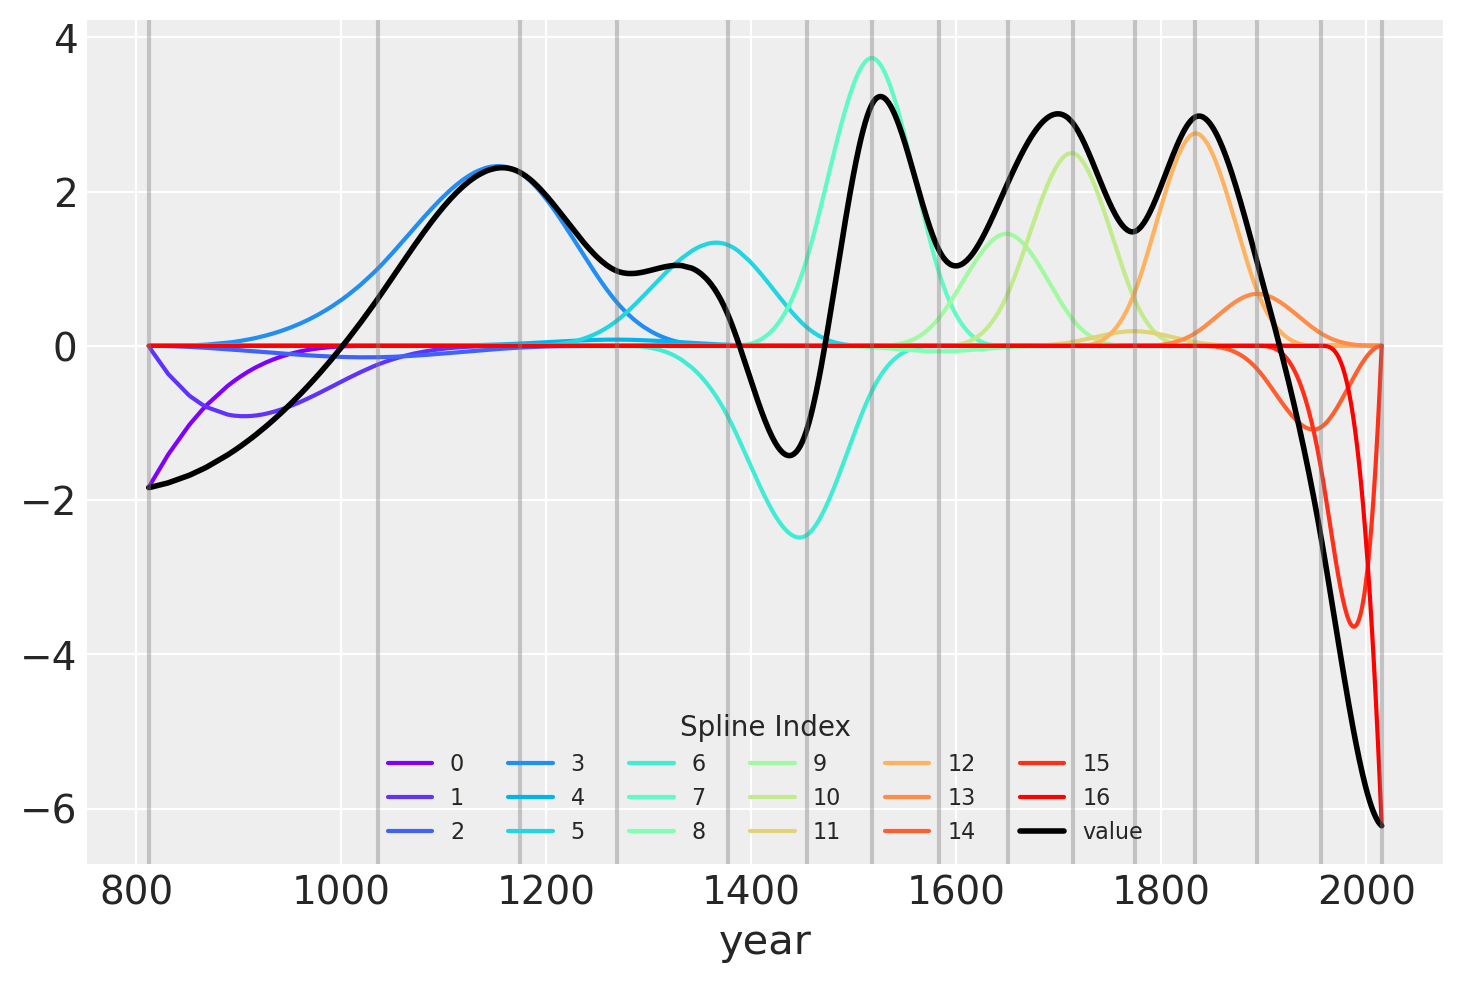

In [17]:
wp = idata.posterior["w"].mean(("chain", "draw")).values

spline_df = (
    pd.DataFrame(B * wp.T)
    .assign(year=blossom_data.year.values)
    .melt("year", var_name = "spline_i", value_name = "value")
)

spline_df_merged = (
    pd.DataFrame(np.dot(B, wp.T))
    .assign(year=blossom_data.year.values)
    .melt("year", var_name = "spline_i", value_name = "value")
)


color = plt.cm.rainbow(np.linspace(0, 1, len(spline_df.spline_i.unique())))
fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("year", "value", c = c, ax = plt.gca(), label = i)
spline_df_merged.plot("year", "value", c = "black", lw = 2, ax = plt.gca())
plt.legend(title = "Spline Index", loc="lower center", fontsize = 8, ncol = 6)

for knot in knot_list:
    plt.gca().axvline(knot, color = "grey", alpha = 0.4);

### Model predictions
最後に、事後予測チェックを使用してモデルの予測を視覚化できます。

In [18]:
post_pred = az.summary(idata, var_names = ["mu"]).reset_index(drop = True)
blossom_data_post = blossom_data.copy().reset_index(drop = True)
blossom_data_post["pred_mean"] = post_pred["mean"]
blossom_data_post["pred_hdi_lower"] = post_pred["hdi_3%"]
blossom_data_post["pred_hdi_upper"] = post_pred["hdi_97%"]

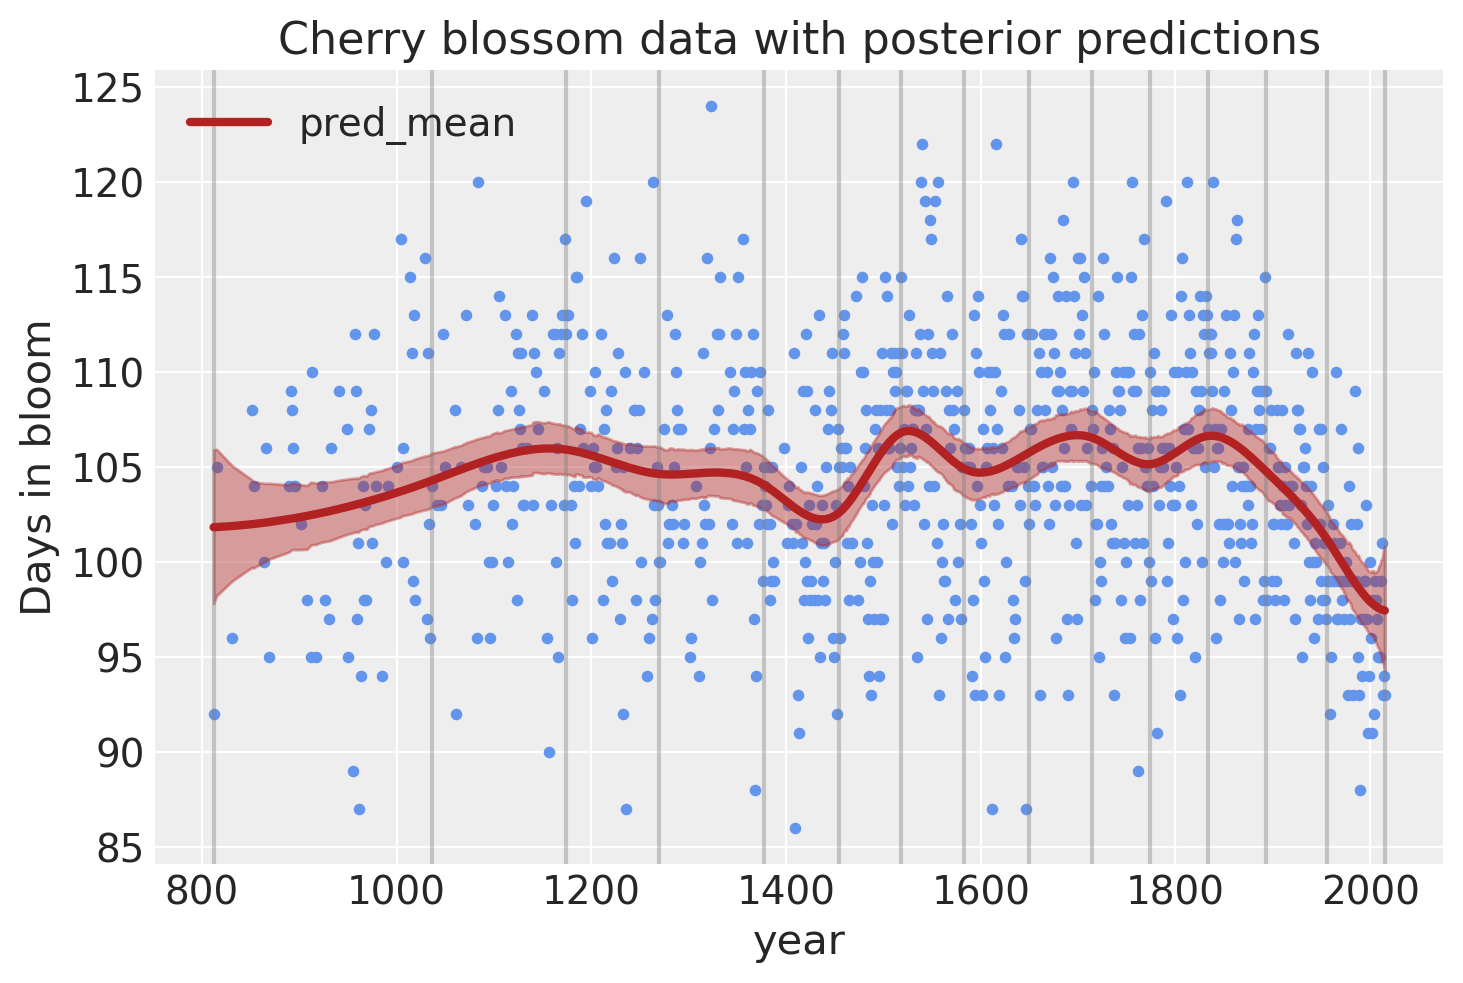

In [19]:
blossom_data.plot.scatter(
    "year",
    "doy",
    color="cornflowerblue",
    s=10,
    title="Cherry blossom data with posterior predictions",
    ylabel="Days in bloom",
)
for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4)

blossom_data_post.plot("year", "pred_mean", ax = plt.gca(), lw = 3, color = "firebrick")
plt.fill_between(
    blossom_data_post.year,
    blossom_data_post.pred_hdi_lower,
    blossom_data_post.pred_hdi_upper,
    color = "firebrick",
    alpha = 0.4,
);

## References
1. Osvaldo A Martin, Ravin Kumar, and Junpeng Lao. Bayesian Modeling and Computation in Python. Chapman and Hall/CRC, 2021. doi:10.1201/9781003019169.
1. Richard McElreath. Statistical rethinking: A Bayesian course with examples in R and Stan. Chapman and Hall/CRC, 2018.

## Authors
* Created by Joshua Cook
* Updated by Tyler James Burch
* Updated by Chris Fonnesbeck

## Watermark

In [20]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray,patsy

Last updated: Tue Apr 09 2024

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

pytensor: 2.20.0
xarray  : 2024.3.0
patsy   : 0.5.6

pandas    : 2.2.1
arviz     : 0.18.0
numpy     : 1.26.4
matplotlib: 3.8.4
pymc      : 5.13.0

Watermark: 2.4.3



## License notice
All the notebooks in this example gallery are provided under the [MIT License]() which allows modification, and redistribution for any use provided the copyright and license notices are preserved.

## Citing PyMC examples
To cite this notebook, use the DOI provided by Zenodo for the pymc-examples repository.

Here is an citation template in bibtex:
```py
@incollection{citekey,
  author    = "<notebook authors, see above>",
  title     = "<notebook title>",
  editor    = "PyMC Team",
  booktitle = "PyMC examples",
  doi       = "10.5281/zenodo.5654871"
}
```

which once rendered could look like:

Joshua Cook . "Splines". In: PyMC Examples. Ed. by PyMC Team. DOI: 10.5281/zenodo.5654871